**Info Regarding New Data**

- Below df's contain idifferent info all combined with the sequence number of the individual.
- No explicit data about T2 Diabetes - would need to calculate from other features.
- Lots more data can be added **Need to research what other features could be useful**
- The codes of the columns are found at https://wwwn.cdc.gov/nchs/nhanes/search/datapage.aspx?Component=Laboratory&Cycle=2021-2023. **Rename columns**

In [12]:
import pandas as pd
import os
import glob

# Path to the directory containing your NHANES datasets
data_dir = '/workspaces/Final-Year-Project/data/NHANES/'

# Define the list of files and the variables of interest from each file
nhanes_files_variables = {
    'BMX_L.XPT': ['SEQN', 'BMXWAIST', 'BMXWT', 'BMXBMI', 'BMXARMC', 'BMXHIP'],
    'BPQ_L.XPT': ['SEQN', 'BPQ150', 'BPQ101D', 'BPQ020', 'BPQ080'],
    'BPXO_L.XPT': ['SEQN', 'BPXOSY1', 'BPXOSY2', 'BPXOSY3'],
    'FNQ_L.XPT': ['SEQN', 'FNQ440'],
    'HUQ_L.XPT': ['SEQN', 'HUQ010'],
    'LUX_L.XPT': ['SEQN', 'LUXSMED', 'LUXCAPM'],
    'MCQ_L.XPT': ['SEQN', 'MCQ160A'],
    'OHQ_L.XPT': ['SEQN', 'OHQ845'],
    'PAQ_L.XPT': ['SEQN', 'PAD810Q'],
    'RXQ_RX_L.XPT': ['SEQN', 'RXQ050'],
    'RXQASA_L.XPT': ['SEQN', 'RXQ510'],
    'SMQ_L.XPT': ['SEQN', 'SMAQUEX2', 'SMD630', 'SMD641'],
    'WHQ_L.XPT': ['SEQN', 'WHD020', 'WHD050'],
    'RHQ_L.XPT': ['SEQN', 'RHQ031', 'RHD280'],
    'OCQ_L.XPT': ['SEQN', 'OCD150'],
    'DEMO_L.XPT': ['SEQN', 'DMDYRUSR', 'RIDAGEYR'],
    'GHB_L.XPT': ['SEQN', 'LBXGH'],  # Glycohemoglobin
}

# Initialize an empty DataFrame to collect the selected data
df_selected = pd.DataFrame()

# Special codes to exclude
special_codes = [7, 8, 9]

# Loop through the files and load the selected variables
for file, variables in nhanes_files_variables.items():
    file_path = os.path.join(data_dir, file)
    try:
        # Load the dataset
        df = pd.read_sas(file_path, format='xport', encoding='iso-8859-1')
        
        # Ensure column names are strings
        df.columns = df.columns.map(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
        
        # Select only the required variables
        df = df[variables]
        
        # Replace special codes with NaN
        df = df.replace(special_codes, pd.NA)
        
        # Merge with the main DataFrame on 'SEQN'
        if df_selected.empty:
            df_selected = df
        else:
            df_selected = pd.merge(df_selected, df, on='SEQN', how='outer')
    
    except Exception as e:
        print(f'Error processing {file}: {e}')

# Drop rows with missing 'SEQN' and any columns with fewer than 3000 non-null values
df_selected = df_selected.dropna(subset=['SEQN'])
df_selected = df_selected.loc[:, df_selected.notna().sum() >= 3000]

# Drop rows where 'LBXGH' (glycohemoglobin) is missing
df_selected = df_selected.dropna(subset=['LBXGH'])

# Convert glycohemoglobin (LBXGH) to categorical diabetes status
# < 5.7% is in range, >= 5.7% & < 6.4% is Prediabetes, >= 6.4% is Diabetes
df_selected['diabetes'] = pd.cut(
    df_selected['LBXGH'],
    bins=[-float('inf'), 5.7, 6.4, float('inf')],
    labels=[0, 1, 2]  # 0: In Range, 1: Prediabetes, 2: Diabetes
)

# Drop the 'LBXGH' column after creating 'diabetes'
df_selected = df_selected.drop(columns=['LBXGH'])

# Drop rows with any remaining NaN values
df_selected = df_selected.dropna()

# Save the selected data to a CSV file
output_file = os.path.join(data_dir, 'home_measurable_variables_with_diabetes.csv')
df_selected.to_csv(output_file, index=False)
print(f"Dataset with home-measurable/self-reported variables and diabetes status saved to {output_file}")
df_selected.info()


Dataset with home-measurable/self-reported variables and diabetes status saved to /workspaces/Final-Year-Project/data/NHANES/home_measurable_variables_with_diabetes.csv
<class 'pandas.core.frame.DataFrame'>
Index: 1413 entries, 2 to 11932
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   SEQN      1413 non-null   float64 
 1   BMXWAIST  1413 non-null   float64 
 2   BMXWT     1413 non-null   object  
 3   BMXBMI    1413 non-null   float64 
 4   BMXARMC   1413 non-null   float64 
 5   BMXHIP    1413 non-null   float64 
 6   BPQ101D   1413 non-null   object  
 7   BPQ020    1413 non-null   object  
 8   BPQ080    1413 non-null   object  
 9   BPXOSY1   1413 non-null   float64 
 10  BPXOSY2   1413 non-null   float64 
 11  BPXOSY3   1413 non-null   float64 
 12  FNQ440    1413 non-null   object  
 13  HUQ010    1413 non-null   object  
 14  LUXSMED   1413 non-null   object  
 15  LUXCAPM   1413 non-null   float64 
 16  MCQ

In [29]:
diabetes_counts = df_selected['diabetes'].value_counts().sort_index()
diabetes_counts

diabetes
0    842
1    385
2    186
Name: count, dtype: int64

In [37]:
from sklearn.utils import resample
import os

# Separate each class into different DataFrames
no_diabetes = df_selected[df_selected['diabetes'] == 0]
prediabetes = df_selected[df_selected['diabetes'] == 1]
diabetes = df_selected[df_selected['diabetes'] == 2]

# Downsample No Diabetes and Prediabetes classes to match the Diabetes count
no_diabetes_downsampled = resample(no_diabetes, replace=False, n_samples=len(diabetes), random_state=42)
prediabetes_downsampled = resample(prediabetes, replace=False, n_samples=len(diabetes), random_state=42)

# Combine all classes to create a balanced dataset
df_balanced = pd.concat([no_diabetes_downsampled, prediabetes_downsampled, diabetes])

# Shuffle the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Define the path for saving
data_dir = '/workspaces/Final-Year-Project/data/NHANES/'
output_file = os.path.join(data_dir, 'home_measurable_variables_balanced_diabetes.csv')

# Save the balanced dataset to a CSV file
df_balanced.to_csv(output_file, index=False)

# Check the class distribution after downsampling
print("Class distribution after downsampling:")
print(df_balanced['diabetes'].value_counts())
print(f"Dataset saved to {output_file}")


Class distribution after downsampling:
diabetes
0    186
1    186
2    186
Name: count, dtype: int64
Dataset saved to /workspaces/Final-Year-Project/data/NHANES/home_measurable_variables_balanced_diabetes.csv


In [38]:
df_corr = df_balanced.corr() 
df_top = df_corr['diabetes'].abs().sort_values(ascending=False)

df_top

diabetes    1.000000
HUQ010      0.412199
BMXWAIST    0.366147
LUXCAPM     0.335262
RXQ050      0.333062
OHQ845      0.330398
BMXBMI      0.308478
FNQ440      0.304821
BMXARMC     0.281578
BPQ101D     0.263555
BMXWT       0.256154
BMXHIP      0.253759
RXQ510      0.212908
BPQ020      0.193931
OCD150      0.174226
BPQ080      0.168284
RHQ031      0.156216
BPXOSY3     0.123832
BPXOSY1     0.122025
MCQ160A     0.114459
BPXOSY2     0.113868
LUXSMED     0.113816
RIDAGEYR    0.109134
PAD810Q     0.060328
SEQN        0.049016
WHD050      0.046190
WHD020      0.011447
SMAQUEX2         NaN
Name: diabetes, dtype: float64

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import numpy as np

# Load the dataset
data_path = '/workspaces/Final-Year-Project/data/NHANES/home_measurable_variables_balanced_diabetes.csv'
data = pd.read_csv(data_path)

# Define features and target
features = ['BMXWAIST', 'LUXCAPM', 'BMXBMI', 'HUQ010', 'BMXARMC', 'RXQ050', 
            'BMXWT', 'FNQ440', 'BMXHIP', 'OHQ845', 'BPQ020', 'BPQ101D', 'RXQ510']
X = data[features]
y = data['diabetes']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Set up cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Tune Random Forest
rf_params = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 5]
}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=kf, scoring='accuracy', n_jobs=-1)
rf_grid.fit(X, y)
best_rf = rf_grid.best_estimator_

print("\nRandom Forest Best Parameters:", rf_grid.best_params_)
print("Mean Accuracy with Best Parameters:", rf_grid.best_score_)

# Evaluate the tuned Random Forest model
y_pred_rf = best_rf.predict(X)
print("\nRandom Forest Classification Report:")
print(classification_report(y, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred_rf))

# Tune Gradient Boosting with early stopping
gb_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 5],
    'subsample': [0.7, 0.8, 0.9]
}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=kf, scoring='accuracy', n_jobs=-1)
gb_grid.fit(X, y)
best_gb = gb_grid.best_estimator_

print("\nGradient Boosting Best Parameters:", gb_grid.best_params_)
print("Mean Accuracy with Best Parameters:", gb_grid.best_score_)

# Evaluate the tuned Gradient Boosting model
y_pred_gb = best_gb.predict(X)
print("\nGradient Boosting Classification Report:")
print(classification_report(y, y_pred_gb))
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred_gb))



Random Forest Best Parameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 100}
Mean Accuracy with Best Parameters: 0.5106818181818181

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       186
           1       0.71      0.68      0.69       186
           2       0.70      0.78      0.74       186

    accuracy                           0.73       558
   macro avg       0.73      0.73      0.73       558
weighted avg       0.73      0.73      0.73       558

Confusion Matrix:
[[134  28  24]
 [ 21 127  38]
 [ 16  25 145]]

Gradient Boosting Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.8}
Mean Accuracy with Best Parameters: 0.5213311688311688

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.72      0.72       186


In [56]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# Load the dataset
data_path = '/workspaces/Final-Year-Project/data/NHANES/home_measurable_variables_balanced_diabetes.csv'
data = pd.read_csv(data_path)

# Define features and target
features = ['BMXWAIST', 'LUXCAPM', 'BMXBMI', 'HUQ010', 'BMXARMC', 'RXQ050', 
            'BMXWT', 'FNQ440', 'BMXHIP', 'OHQ845', 'BPQ020', 'BPQ101D', 'RXQ510']
X = data[features]
y = data['diabetes']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Initialize the Decision Tree model
dt = DecisionTreeClassifier(random_state=42)

# Set up the hyperparameter grid for tuning
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Use GridSearchCV to find the best parameters with 5-fold cross-validation
grid_search = GridSearchCV(
    dt, param_grid, scoring='accuracy', cv=KFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1, verbose=1
)
grid_search.fit(X, y)

# Get the best model
best_dt = grid_search.best_estimator_

# Evaluate the model with the best parameters
y_pred = best_dt.predict(X)
print("Best Parameters for Decision Tree:", grid_search.best_params_)
print("Mean Accuracy with Best Parameters:", grid_search.best_score_)

# Classification report and confusion matrix
print("Decision Tree Classification Report:")
print(classification_report(y, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for Decision Tree: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean Accuracy with Best Parameters: 0.4783462033462034
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.65      0.67       186
           1       0.59      0.61      0.60       186
           2       0.64      0.66      0.65       186

    accuracy                           0.64       558
   macro avg       0.64      0.64      0.64       558
weighted avg       0.64      0.64      0.64       558

Confusion Matrix:
[[121  33  32]
 [ 35 113  38]
 [ 18  46 122]]


In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

# Load the dataset
data_path = '/workspaces/Final-Year-Project/data/NHANES/home_measurable_variables_balanced_diabetes.csv'
data = pd.read_csv(data_path)

# Define features and target
features = ['BMXWAIST', 'LUXCAPM', 'BMXBMI', 'HUQ010', 'BMXARMC', 'RXQ050', 
            'BMXWT', 'FNQ440', 'BMXHIP', 'OHQ845', 'BPQ020', 'BPQ101D', 'RXQ510']
X = data[features]
y = data['diabetes']

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Initialize Decision Tree with initial parameters
dt = DecisionTreeClassifier(random_state=42)

# Set up parameter grid to allow controlled complexity
param_grid = {
    'max_depth': [4, 5, 6, 7],
    'min_samples_split': [3, 5, 7],
    'min_samples_leaf': [2, 3, 5]
}

# Cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Run GridSearchCV with adjusted parameter grid
grid_search = GridSearchCV(dt, param_grid, scoring='accuracy', cv=kf, n_jobs=-1, verbose=1)
grid_search.fit(X, y)

# Retrieve the best model
best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X)

# Output the best parameters and mean accuracy score from cross-validation
print("Best Parameters for Decision Tree:", grid_search.best_params_)
print("Mean Accuracy with Best Parameters:", grid_search.best_score_)

# Evaluate the model with classification report and confusion matrix
print("Decision Tree Classification Report:")
print(classification_report(y, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y, y_pred))


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters for Decision Tree: {'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 3}
Mean Accuracy with Best Parameters: 0.481981981981982
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.75      0.72       186
           1       0.62      0.70      0.66       186
           2       0.79      0.63      0.70       186

    accuracy                           0.69       558
   macro avg       0.70      0.69      0.69       558
weighted avg       0.70      0.69      0.69       558

Confusion Matrix:
[[139  32  15]
 [ 40 130  16]
 [ 23  46 117]]


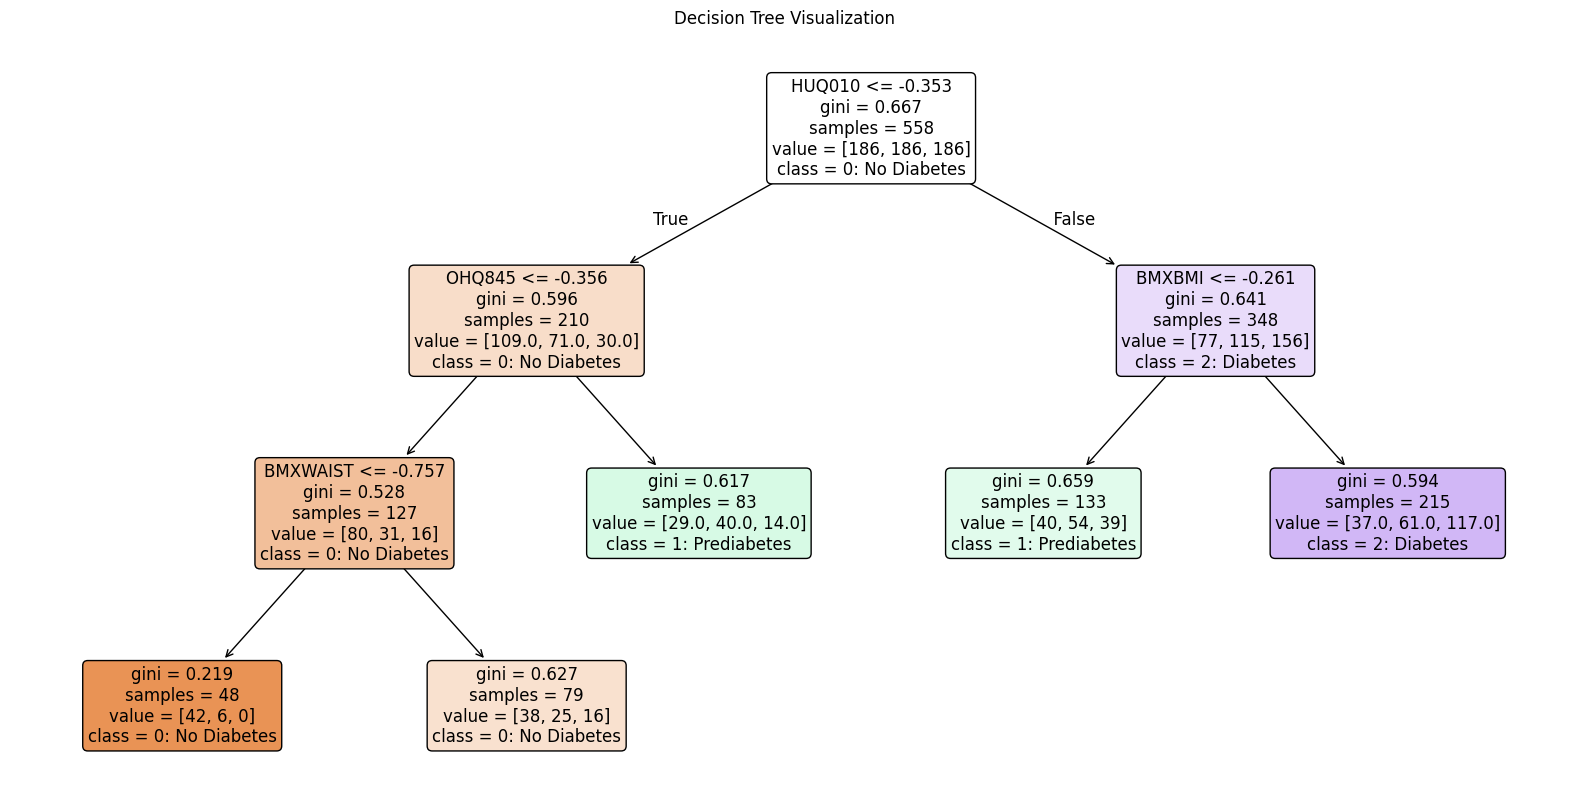

In [67]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Visualize the decision tree
plt.figure(figsize=(20,10))  # Set the size of the figure for better readability
plot_tree(best_dt, 
          filled=True,  # Color the nodes according to the class label
          feature_names=features,  # Names of features in the model
          class_names=["0: No Diabetes", "1: Prediabetes", "2: Diabetes"],  # Class names
          rounded=True,  # Rounded corners for nodes
          fontsize=12)  # Set font size for better readability

# Display the tree
plt.title("Decision Tree Visualization")
plt.show()
